In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt

from utils.dataset import PreloadedDataset
from utils.train import train_denoise
from utils.extra_funcs import HopfieldActivation
from model import HopfieldNetwork

c:\Users\Joe\anaconda3\envs\ml-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
DATA_RATIO = 0.001 # portion of dataset to use
VAL_RATIO = 0.2

transform = transforms.Compose([
    transforms.ToTensor(),
    HopfieldActivation(0.5), # set images to -1 or 1
    # transforms.Normalize((0.1307,), (0.3081,)),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1))
])

dataset = datasets.MNIST(root="datasets/", train=True, transform=transform, download=True)
# reduce dataset size
dataset = torch.utils.data.Subset(dataset, range(int(len(dataset) * DATA_RATIO)))
# dataset = torch.utils.data.Subset(dataset, range(1))

val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, transforms.ToTensor(), device)
# val_dataset = PreloadedDataset.from_dataset(val_dataset, transforms.ToTensor(), device)
INPUT_SHAPE = train_dataset[0][0].shape
NUM_CLASSES = 10
print(f'Loaded MNIST dataset with {len(train_dataset)} training samples')#and {len(val_dataset)} validation samples')

Loaded MNIST dataset with 48 training samples


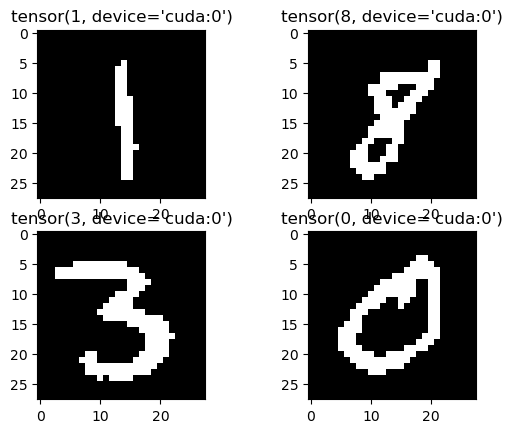

In [39]:
# Show 4 random images from the training dataset in grid
fig, ax = plt.subplots(2, 2)
for i in range(2):
    for j in range(2):
        idx = torch.randint(0, len(train_dataset), (1,)).item()
        image = train_dataset[idx][0].squeeze().cpu()
        ax[i, j].imshow(image, cmap="gray")
        ax[i, j].set_title(train_dataset[idx][1])
plt.show()


In [74]:
# Hebbian Learning
torch.manual_seed(42)
model_name = "mnist_hopfield_hebbian"
size = 1
for dim in INPUT_SHAPE:
    size *= dim
model = HopfieldNetwork(size, bias=False, steps=5).to(device)
step = 0

In [77]:
LR = 5e-4
BATCH_SIZE=16
epochs = 1000
criterion = nn.MSELoss()
optimiser = optim.AdamW(model.parameters(), lr=LR)
energy, step = train_denoise(model, train_dataset, val_dataset, optimiser, criterion, model_name, epochs, minimise='loss', batch_size=BATCH_SIZE, flatten=True, step=step, device=device)
print(f"Final energy: {energy[-1]}")

Final energy: 7.835527503630146e-05


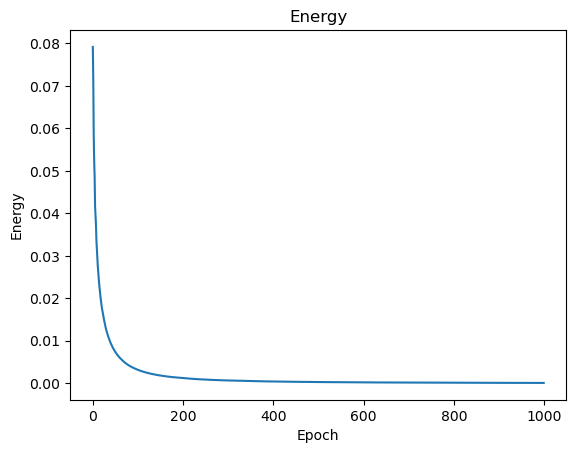

In [78]:
# plot energy
plt.plot(energy)
plt.title("Energy")
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.show()